In [1]:
import os, sys
import logging
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = "/Users/shawn/Documents/personal/rsi_divergence_detector"
sys.path.append(PROJECT_PATH)
# Load the training data
# Replace 'training_data.csv' with your actual data file or DataFrame
df = pd.read_pickle(f'{PROJECT_PATH}/data/processed_data/training_data.pickle')
divergence_data = pd.read_pickle(f"{PROJECT_PATH}/data/processed_data/divergence_data.pickle")

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)


In [2]:
# Test dataframes sliced
df_5m = df[df.timeframe == '5m']
df_5m_filter = df_5m.loc[df_5m.index > '2024-11-20 00:30:00']
# df_5m_filter = df_5m_filter.loc[df_5m_filter.index < '2024-11-22 20:00:00']

df_total = df_5m_filter
df_divergence = divergence_data['15m']


In [3]:
df_total.head(3)

,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,willr,cci,atr,return_1,return_5,return_10,volatility_5,volatility_10,volume_change,volume_rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-20 00:35:00,1732062900000,92080.35,92260.0,92050.53,92260.00,50.34613,5m,54.149277,9.696354,-7.417105,...,-37.900067,13.364110,194.759931,0.001951,0.000873,0.001121,0.001268,0.001520,-0.287841,58.752716
2024-11-20 00:40:00,1732063200000,92259.99,92320.0,92233.69,92233.70,69.42001,5m,53.172138,15.807042,-2.772276,...,-44.181714,87.280919,187.013507,-0.000285,0.001365,0.001378,0.001193,0.001510,0.378855,62.958378
2024-11-20 00:45:00,1732063500000,92233.69,92260.0,92124.51,92130.93,55.29224,5m,49.419335,12.216304,0.225440,...,-68.727907,-21.628155,183.333257,-0.001114,-0.000337,-0.001948,0.001317,0.001361,-0.203511,62.781558


In [4]:
df_divergence

,end_datetime,entry_datetime,entry_price,previous_peak_datetime,divergence,price_change,rsi_change,TP,SL,label,...,SL_percent,position,TP_vs_SL,TP_/_SL,profit,div_5m,div_15m,div_1h,div_4h,div_1d
start_datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 16:15:00,2017-08-17 18:00:00,2017-08-17 18:30:00,4287.69,2017-08-17 14:30:00,Bullish Divergence,5.18,6.47,4320.56,4218.68,False,...,1.61,False,0.476354,0.48,-69.01,False,True,False,False,False
2017-08-17 18:30:00,2017-08-18 01:15:00,2017-08-18 01:45:00,4231.61,2017-08-17 14:30:00,Bullish Divergence,37.98,10.29,4268.61,4134.61,True,...,2.29,False,0.381422,0.38,37.00,False,True,False,False,False
2017-08-17 18:30:00,2017-08-18 15:15:00,2017-08-18 15:45:00,4248.00,2017-08-17 14:30:00,Bullish Divergence,36.84,13.37,4314.89,4209.50,False,...,0.91,False,1.737402,1.74,-38.50,False,True,False,False,False
2017-08-18 19:00:00,2017-08-18 20:15:00,2017-08-18 20:45:00,4015.40,2017-08-18 10:30:00,Bullish Divergence,-34.90,-1.32,4148.66,4010.90,False,...,0.11,True,29.612631,29.61,-4.50,True,True,False,False,False
2017-08-18 19:00:00,2017-08-18 21:45:00,2017-08-18 22:15:00,4061.00,2017-08-18 10:30:00,Bullish Divergence,125.71,21.95,4121.34,3966.69,True,...,2.32,False,0.639753,0.64,60.34,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04 20:30:00,2024-12-06 14:15:00,2024-12-06 14:45:00,98827.76,2024-12-04 16:45:00,Bearish Divergence,-78.12,-7.39,97495.01,99292.00,False,...,0.47,False,2.870827,2.87,-464.24,False,True,False,False,False
2024-12-04 20:30:00,2024-12-06 14:45:00,2024-12-06 15:15:00,98832.73,2024-12-04 16:45:00,Bearish Divergence,-145.69,-4.56,97613.55,99483.81,False,...,0.66,False,1.872557,1.87,-651.08,False,True,False,False,False
2024-12-06 18:15:00,2024-12-06 19:30:00,2024-12-06 20:00:00,101439.99,2024-12-06 12:45:00,Bearish Divergence,-308.25,-9.06,100100.28,101700.00,False,...,0.26,True,5.152520,5.15,-260.01,False,True,False,False,False


## Joining divergence data and price data

In [102]:
def create_divergence_sequence(df5, divergence_data):
    """
    Create a divergence feature sequence aligned with df5 timestamps for multiple timeframes.
    divergence_data: { '5m': ddf_5m, '1h': ddf_1h, ... }
    Each ddf_x: has divergence info with timestamps. For each timestamp in df5, 
    we check if there's a bullish divergence (1), bearish divergence (-1), else 0.
    
    This is just an example. You need to adapt it based on how you store divergence info.
    """
    # Initialize a dict of arrays, one per timeframe
    divergence_arrays = {}
    for tf, ddf in divergence_data.items():
        # Assume ddf indexed by datetime with a column 'divergence' that can be 'Bullish' or 'Bearish' or None
        # We'll create an array aligned with df5 index
        arr = np.zeros(len(df5), dtype=np.float32)
        # For each event in ddf, mark the corresponding timestamps
        # This is a simplistic approach: if end_datetime in ddf matches a df5 timestamp,
        # set arr[idx] = 1 for bullish, -1 for bearish.
        # You may need a more sophisticated approach depending on your data.
        for start_dt, event in ddf.iterrows():
            end_dt = event['end_datetime']
        
            for time_delta in range(0, int((end_dt - start_dt).total_seconds()) + 1, 5*60):
                t = start_dt + pd.Timedelta(seconds=time_delta)
                if t in df5.index:
                    idx = df5.index.get_loc(t)
                    if event['divergence'] == 'Bullish Divergence':
                        arr[idx] = 1
                    elif event['divergence'] == 'Bearish Divergence':
                        arr[idx] = -1
        
        divergence_arrays[tf] = arr
    
    # Combine into a single DataFrame (or array)
    # For simplicity, just stack them column-wise
    divergence_df = pd.DataFrame(index=df5.index)
    for tf, arr in divergence_arrays.items():
        df5[f"div_{tf}"] = arr
    
    return df5

In [103]:
import time
t = time.time()
df_revised = create_divergence_sequence(df_5m, divergence_data)
print(f"{time.time() - t} taken.")

81.59271025657654 taken.


/var/folders/ns/shg9ht0545sbbr41sk4q_zgr0000gn/T/ipykernel_44174/1955272509.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[f"div_{tf}"] = arr


In [107]:
df_revised.div_5m.value_counts()

div_5m
 0.0    320334
-1.0    233313
 1.0    213451
Name: count, dtype: int64

## Train LSTM

In [ ]:
from src.dataset.lstm_dataset import LSTMDivergenceDataset, create_divergence_sequence
from src.model.lstm_mixed import MixedLSTMModel
from src.training.train_lstm import train_model, evaluate_model, plot_results, model_naming


In [ ]:
df = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'training_data.pickle'))
divergence_data = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'divergence_data.pickle'))

# Filter 5-minute timeframe data
# price_df = df[df['timeframe'] == '5m'].copy()
price_df = pd.read_pickle(f"{PROJECT_PATH}/data/training_data/price_df.pickle")
divergence_df = divergence_data['15m'].copy()  # Assuming '5m' key exists

# Split divergence_df into train/val/test
total_events = len(divergence_df)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_count = int(total_events * train_ratio)
val_count = int(total_events * val_ratio)
test_count = total_events - train_count - val_count

divergence_df_train = df_divergence.iloc[:train_count]
divergence_df_val = df_divergence.iloc[train_count:train_count+val_count]
divergence_df_test = df_divergence.iloc[train_count+val_count:]


In [ ]:

logger.info(f"Train events: {len(divergence_df_train)}, "
            f"Validation events: {len(divergence_df_val)}, "
            f"Test events: {len(divergence_df_test)}")

# Prepare divergence_data for multiple timeframes (if applicable)
# Assuming divergence_data contains multiple timeframes
# Example: divergence_data = {'5m': ddf_5m, '15m': ddf_15m, '1h': ddf_1h, ...}
# For simplicity, using only '5m' here
divergence_data_subset = {'15m': divergence_df_train}

# Initialize Dataset
logger.info("Initializing datasets...")
train_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_train, 
                                        price_df=price_df, 
                                        divergence_data=divergence_data, 
                                        seq_length=288)  # 288 * 5min = 24 hours
# Use the same scaler for validation and test
scaler = train_dataset.scaler
val_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_val, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)

test_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_test, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

2024-12-11 23:11:37,710 INFO Train events: 5812, Validation events: 1660, Test events: 831
2024-12-11 23:11:37,711 INFO Initializing datasets...


In [ ]:
pd.to_pickle(train_dataset, f"{PROJECT_PATH}/data/training_data/train_dataset.pickle")
pd.to_pickle(val_dataset, f"{PROJECT_PATH}/data/training_data/val_dataset.pickle")
pd.to_pickle(test_dataset, f"{PROJECT_PATH}/data/training_data/test_dataset.pickle")

pd.to_pickle(train_loader, f"{PROJECT_PATH}/data/training_data/test_loader.pickle")
pd.to_pickle(val_loader, f"{PROJECT_PATH}/data/training_data/test_loader.pickle")
pd.to_pickle(test_loader, f"{PROJECT_PATH}/data/training_data/test_loader.pickle")

In [ ]:

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Initialize Model
model_args = {
    "seq_input_dim": len(train_dataset.ts_cols),
    "seq_hidden_dim": 128,
    "seq_num_layers": 3,
    "nonseq_input_dim": len(train_dataset.nonseq_cols),
    "mlp_hidden_dim": 256,
    "num_classes": 2,
    "dropout": 0.3
}
model = MixedLSTMModel(**model_args)
logger.info(f"Model initialized with args: {model_args}")

# Generate model name
model_name = model_naming(**model_args)
model_save_path = os.path.join(PROJECT_PATH, 'model_data', 'mixed_lstm', model_name)


2024-12-11 23:11:39,906 INFO Using device: cpu
2024-12-11 23:11:39,909 INFO Model initialized with args: {'seq_input_dim': 29, 'seq_hidden_dim': 128, 'seq_num_layers': 3, 'nonseq_input_dim': 6, 'mlp_hidden_dim': 256, 'num_classes': 2, 'dropout': 0.3}


In [ ]:
# Train the model
import warnings
warnings.filterwarnings('ignore')

logger.info("Starting training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=500,
    lr=1e-3,
    device=device,
    log_interval=10,
    save_path=model_save_path
)

# Load the best model
logger.info("Loading the best model for testing...")
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Evaluate on test set
logger.info("Evaluating on test set...")
    # After evaluating on the test set
test_metrics = evaluate_model(model, test_loader, device)
logger.info(f"Test Metrics: {test_metrics}")

metrics_path = os.path.join(PROJECT_PATH, 'model_data', 'mixed_lstm', 'metrics.pkl')
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy']
}
# Save the extended metrics
metrics['test_precision'] = test_metrics['precision']
metrics['test_recall'] = test_metrics['recall']
metrics['test_f1_score'] = test_metrics['f1_score']
metrics['test_confusion_matrix'] = test_metrics['confusion_matrix']

pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")

# Plot training and validation metrics
logger.info("Plotting training results...")
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=os.path.join(PROJECT_PATH, 'plots'))


2024-12-12 10:13:07,456 INFO Starting training...
2024-12-12 10:13:11,729 INFO Epoch [1/500], Batch [10/90], Loss: 6.7485
2024-12-12 10:13:16,305 INFO Epoch [1/500], Batch [20/90], Loss: 1.5336
2024-12-12 10:13:20,931 INFO Epoch [1/500], Batch [30/90], Loss: 2.4667
2024-12-12 10:13:25,404 INFO Epoch [1/500], Batch [40/90], Loss: 1.4954
2024-12-12 10:13:29,928 INFO Epoch [1/500], Batch [50/90], Loss: 0.6979
2024-12-12 10:13:34,466 INFO Epoch [1/500], Batch [60/90], Loss: 0.9215
2024-12-12 10:13:38,808 INFO Epoch [1/500], Batch [70/90], Loss: 0.6387
2024-12-12 10:13:43,508 INFO Epoch [1/500], Batch [80/90], Loss: 0.9307
2024-12-12 10:13:48,326 INFO Epoch [1/500], Batch [90/90], Loss: 0.8169
2024-12-12 10:13:53,157 INFO Epoch [1/500] - Train Loss: 1.9638, Train Acc: 0.6593 - Val Loss: 0.8004, Val Acc: 0.7036
2024-12-12 10:13:53,161 INFO Best model saved with Val Acc: 0.7036
2024-12-12 10:13:57,656 INFO Epoch [2/500], Batch [10/90], Loss: 0.6017
2024-12-12 10:14:01,870 INFO Epoch [2/500], 

In [ ]:
model

MixedLSTMModel(
  (lstm): LSTM(29, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=134, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
divergence_df_test.label.value_counts()

label
False    617
True     214
Name: count, dtype: int64

In [ ]:
model.eval()
criterion = nn.CrossEntropyLoss()
total_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_seq, X_nonseq, y in test_loader:
        X_seq = X_seq.to(device)
        X_nonseq = X_nonseq.to(device)
        y = y.to(device)

        outputs = model(X_seq, X_nonseq)
        loss = criterion(outputs, y)

        total_loss += loss.item() * X_seq.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())


In [ ]:
all_preds.sort()
all_preds

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.in

## Train Transformer

In [6]:
from src.dataset.lstm_dataset import LSTMDivergenceDataset, create_divergence_sequence
from src.model.transformer import TransformerMixedModel
from src.training.train_lstm import train_model, evaluate_model, plot_results, model_naming
from sklearn.utils import class_weight
import numpy as np


In [ ]:
df = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'training_data.pickle'))
divergence_data = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'divergence_data.pickle'))

# Filter 5-minute timeframe data
# price_df = df[df['timeframe'] == '5m'].copy()
price_df = pd.read_pickle(f"{PROJECT_PATH}/data/training_data/price_df.pickle")
divergence_df = divergence_data['15m'].copy()  # Assuming '5m' key exists

# Split divergence_df into train/val/test
total_events = len(divergence_df)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_count = int(total_events * train_ratio)
val_count = int(total_events * val_ratio)
test_count = total_events - train_count - val_count

divergence_df_train = df_divergence.iloc[:train_count]
divergence_df_val = df_divergence.iloc[train_count:train_count+val_count]
divergence_df_test = df_divergence.iloc[train_count+val_count:]


logger.info(f"Train events: {len(divergence_df_train)}, "
            f"Validation events: {len(divergence_df_val)}, "
            f"Test events: {len(divergence_df_test)}")

# Prepare divergence_data for multiple timeframes (if applicable)
# Assuming divergence_data contains multiple timeframes
# Example: divergence_data = {'5m': ddf_5m, '15m': ddf_15m, '1h': ddf_1h, ...}
# For simplicity, using only '5m' here
divergence_data_subset = {'15m': divergence_df_train}

# Initialize Dataset
logger.info("Initializing datasets...")
train_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_train, 
                                        price_df=price_df, 
                                        divergence_data=divergence_data, 
                                        seq_length=288)  # 288 * 5min = 24 hours
# Use the same scaler for validation and test
scaler = train_dataset.scaler
val_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_val, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)

test_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_test, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Initialize Transformer Model
transformer_model_args = {
    "seq_input_dim": len(train_dataset.ts_cols),
    "seq_model_dim": 256,          # You can adjust this as needed
    "seq_num_heads": 8,            # Number of attention heads
    "seq_num_layers": 6,           # Number of Transformer layers
    "nonseq_input_dim": len(train_dataset.nonseq_cols),
    "mlp_hidden_dim": 512,
    "num_classes": 2,
    "dropout": 0.3,
    "max_len": 5000                 # Maximum sequence length
}


transformer_model = TransformerMixedModel(**transformer_model_args)
logger.info(f"Transformer Model initialized with args: {transformer_model_args}")

# Generate model name
transformer_model_name = model_naming(**transformer_model_args)
transformer_model_save_dir = os.path.join(PROJECT_PATH, 'model_data', 'transformer_mixed')
os.makedirs(transformer_model_save_dir, exist_ok=True)
transformer_model_save_path = os.path.join(transformer_model_save_dir, transformer_model_name)

# Calculate class weights for imbalanced loss
classes = np.unique(divergence_df_train['label'])
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=divergence_df_train['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
logger.info(f"Class weights: {class_weights}")

2024-12-12 14:45:19,260 INFO Using device: cpu
/Users/shawn/Library/Caches/pypoetry/virtualenvs/rsi-divergence-detector-MNiR8ro_-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2024-12-12 14:45:19,274 INFO Transformer Model initialized with args: {'seq_input_dim': 29, 'seq_model_dim': 128, 'seq_num_heads': 8, 'seq_num_layers': 3, 'nonseq_input_dim': 6, 'mlp_hidden_dim': 256, 'num_classes': 2, 'dropout': 0.3, 'max_len': 5000}


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(transformer_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Train the Transformer model
logger.info("Starting training of the Transformer model...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=transformer_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler
    epochs=50,
    lr=1e-4,
    device=device,
    log_interval=10,
    save_path=transformer_model_save_path,
    patience=5
)

# Load the best Transformer model
logger.info("Loading the best Transformer model for testing...")
transformer_model.load_state_dict(torch.load(transformer_model_save_path, map_location=device))

# Evaluate the Transformer model on the test set
logger.info("Evaluating on test set...")
test_metrics = evaluate_model(transformer_model, test_loader, device)
logger.info(f"Test Metrics: {test_metrics}")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1_score': test_metrics['f1_score'],
    'test_confusion_matrix': test_metrics['confusion_matrix']
}
metrics_path = os.path.join(transformer_model_save_dir, 'metrics.pkl')
pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")

# Plot training and validation metrics
logger.info("Plotting training results for the Transformer model...")
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=os.path.join(PROJECT_PATH, 'plots'))


2024-12-12 15:58:56,504 INFO Starting training of the Transformer model...
2024-12-12 15:59:10,592 INFO Epoch [1/500], Batch [10/90], Loss: 102.2178
2024-12-12 15:59:24,129 INFO Epoch [1/500], Batch [20/90], Loss: 64.6928
2024-12-12 15:59:37,866 INFO Epoch [1/500], Batch [30/90], Loss: 80.9774
2024-12-12 15:59:52,420 INFO Epoch [1/500], Batch [40/90], Loss: 47.0456
2024-12-12 16:00:07,321 INFO Epoch [1/500], Batch [50/90], Loss: 35.3128
2024-12-12 16:00:21,375 INFO Epoch [1/500], Batch [60/90], Loss: 42.2994
2024-12-12 16:00:34,911 INFO Epoch [1/500], Batch [70/90], Loss: 22.5758
2024-12-12 16:00:48,721 INFO Epoch [1/500], Batch [80/90], Loss: 24.9593
2024-12-12 16:01:03,296 INFO Epoch [1/500], Batch [90/90], Loss: 13.3111
2024-12-12 16:01:07,934 INFO Epoch [1/500] - Train Loss: 45.9228, Train Acc: 0.6428 - Val Loss: 40.8713, Val Acc: 0.7036
2024-12-12 16:01:07,943 INFO Best model saved with Val Acc: 0.7036
2024-12-12 16:01:21,559 INFO Epoch [2/500], Batch [10/90], Loss: 10.7808
2024-1

NameError: name 'metrics' is not defined

In [14]:
# Evaluate the Transformer model on the test set
logger.info("Evaluating on test set...")
    # After evaluating on the test set
test_metrics = evaluate_model(transformer_model, test_loader, device)
logger.info(f"Test Metrics: {test_metrics}")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy']
}
# Save the extended metrics
metrics['test_precision'] = test_metrics['precision']
metrics['test_recall'] = test_metrics['recall']
metrics['test_f1_score'] = test_metrics['f1_score']
metrics['test_confusion_matrix'] = test_metrics['confusion_matrix']

metrics_path = os.path.join(transformer_model_save_dir, 'metrics.pkl')
pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")


# Plot training and validation metrics
logger.info("Plotting training results...")
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=os.path.join(PROJECT_PATH, 'plots'))

2024-12-12 17:53:24,494 INFO Evaluating on test set...
2024-12-12 17:53:26,839 INFO Test Metrics: {'loss': 87.81505947365514, 'accuracy': 0.7424789410348978, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0), 'confusion_matrix': array([[617,   0],
       [214,   0]])}
2024-12-12 17:53:26,841 INFO Metrics saved to /Users/shawn/Documents/personal/rsi_divergence_detector/model_data/transformer_mixed/metrics.pkl
2024-12-12 17:53:26,841 INFO Plotting training results...


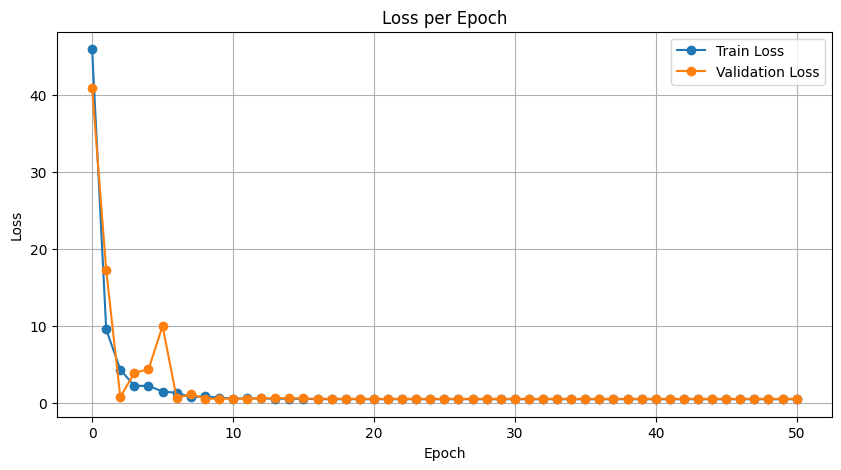

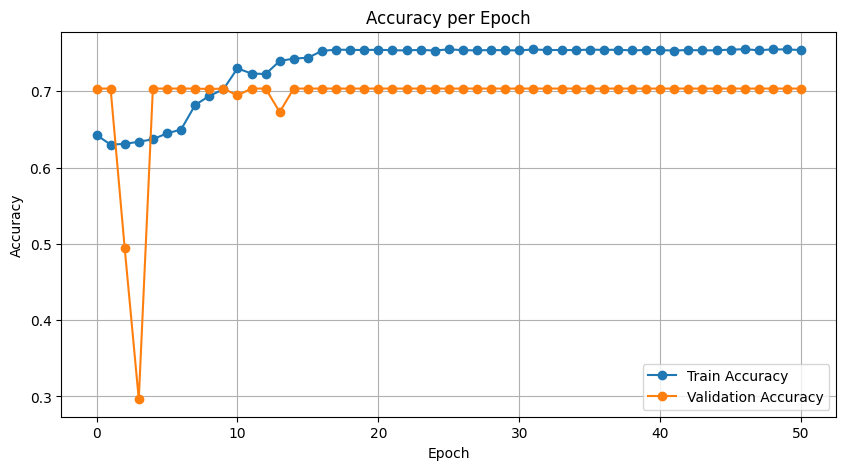

In [16]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir='plots'):
    """
    Plot training and validation loss and accuracy.
    
    Parameters:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    - train_accuracies: List of training accuracies per epoch.
    - val_accuracies: List of validation accuracies per epoch.
    - outdir: Directory to save the plots.
    """
    os.makedirs(outdir, exist_ok=True)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(outdir, 'loss_plot.png'))

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(outdir, 'accuracy_plot.png'))

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=os.path.join(PROJECT_PATH, 'plots'))

In [ ]:
model.eval()
criterion = nn.CrossEntropyLoss()
total_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_seq, X_nonseq, y in test_loader:
        X_seq = X_seq.to(device)
        X_nonseq = X_nonseq.to(device)
        y = y.to(device)

        outputs = model(X_seq, X_nonseq)
        loss = criterion(outputs, y)

        total_loss += loss.item() * X_seq.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())


In [ ]:
all_preds.sort()
all_preds

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.in